In [1]:
from __future__ import annotations
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from makemore import BatchNorm, PytorchifiedBatchNorm, Tanh, Linear, load_words

%matplotlib inline

In [2]:
words: list[str] = open("names.txt", "r").read().splitlines()

In [3]:
# Gets all the characters, a-z
chars: list[str] = sorted(list(set("".join(words))))

# Maps each character to an integer
stoi: dict[str, int] = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0

# Maps each integer to a character
itos: dict[int, str] = {i: s for s, i in stoi.items()}
vocab_size: int = len(stoi)

In [4]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP
n_embd = 10  # Embedding dimension
n_hidden = 200  # Neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (
    (5 / 3) / ((n_embd * block_size) ** 0.5)
)
# Batch normalization layer has its own bias
# b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

# Batch normalization
bngain = torch.ones((1, n_hidden))  # Gamma
bnbias = torch.zeros((1, n_hidden))  # Beta
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

12097


In [7]:
# Scalar you multiply the Gaussian by becomes its std
(torch.randn(10000) * 0.2).std()

tensor(0.1982)

In [8]:
# In Kaiming initialization, the gain is sqrt(2) for ReLU and (5/3) for tanh
# https://pytorch.org/docs/stable/nn.init.html
(5 / 3) / (30**0.5)

0.3042903097250923

tensor(-0.0008) tensor(1.0072)
tensor(-0.0024) tensor(1.0116)


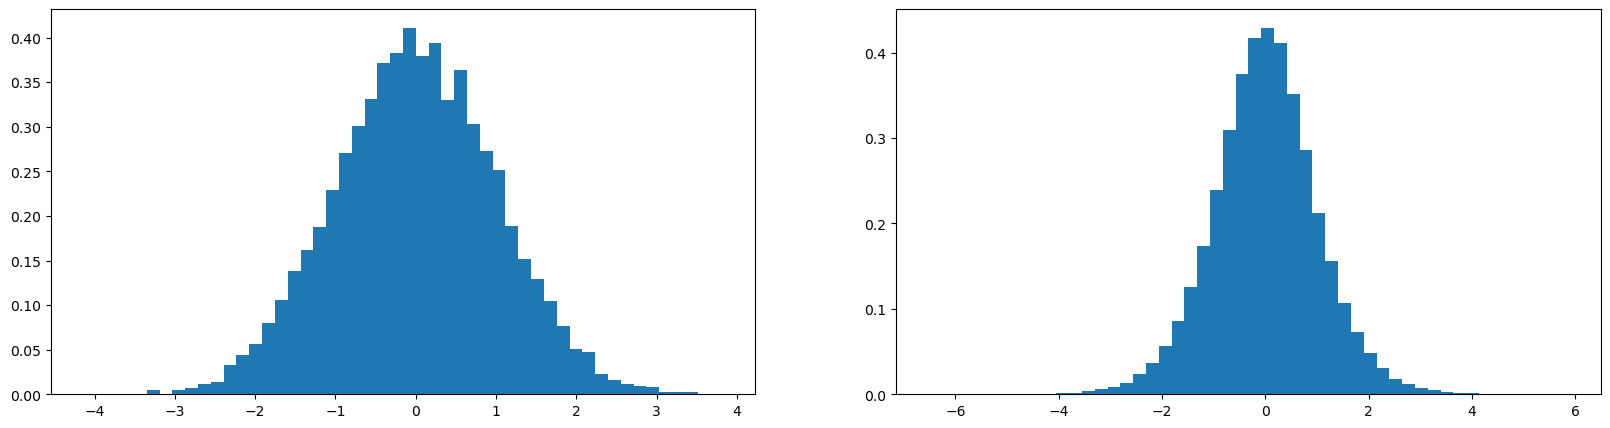

In [9]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1  # + b1  # Hidden layer weighted inputs
    # Batch normalization
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        # Momentum = 0.001
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)  # Hidden layer activations
    logits = h @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Logging
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


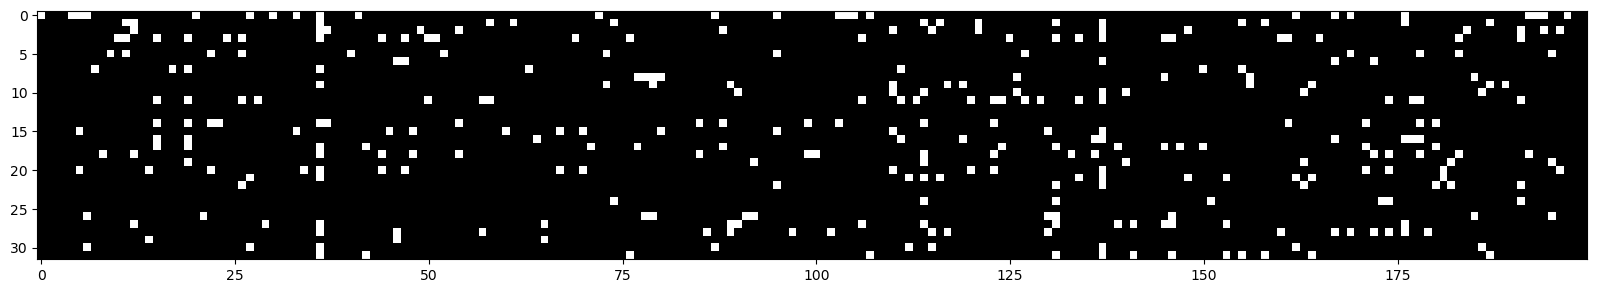

In [11]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

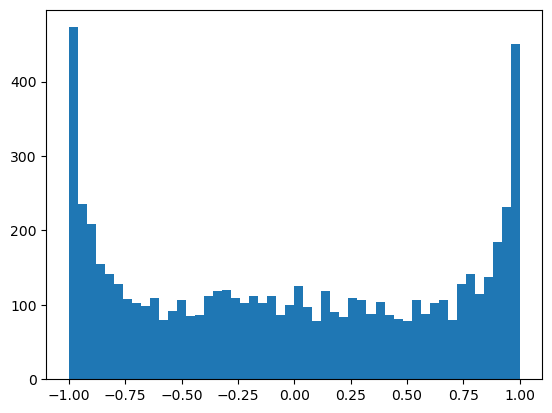

In [12]:
plt.hist(h.view(-1).tolist(), 50);

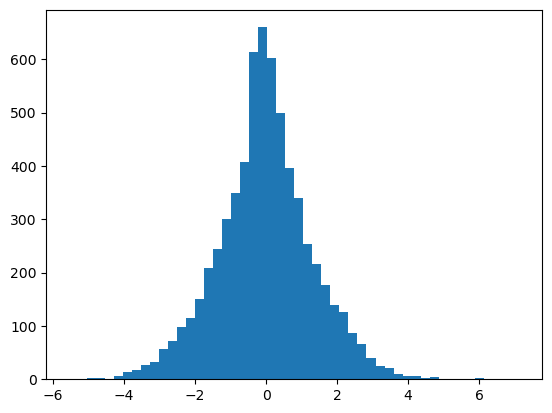

In [13]:
plt.hist(hpreact.view(-1).tolist(), 50);

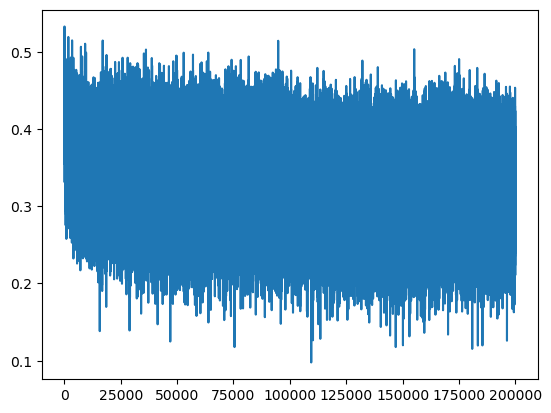

In [14]:
plt.plot(lossi)

In [15]:
# The loss is lowest when the model is confident in its prediction
# Loss tends to be highest when the model is not confident in its prediction
# It is slightly lower when the output values are close to each other
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
# logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 5., 0.]),
 tensor([0.0066, 0.0066, 0.9802, 0.0066]),
 tensor(0.0200))

In [16]:
# Expected starting loss
-torch.tensor(1 / 27.0).log()

tensor(3.2958)

In [17]:
# Explicitly calibrate batchnorm statistics
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1
    # Measure the mean and std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [18]:
bnmean

tensor([[-2.3948,  0.3696, -1.2718,  1.2949,  0.9555,  0.9955,  1.5502, -1.9208,
          1.1124,  1.2444, -1.8118, -2.7730,  0.0738, -0.6075,  0.4335, -0.6823,
          0.7747, -2.1882, -0.1999,  1.5907, -0.8760,  0.0857, -0.2508,  0.4101,
          1.0317,  1.6305,  1.1978,  0.9557,  0.3583,  1.9510, -0.0680, -1.2067,
         -0.1050, -0.2660, -0.4748, -1.4983, -2.6133,  0.0533, -0.0121,  0.6010,
         -0.2272, -0.8899, -0.2851, -0.1833,  0.6506,  0.8990,  1.5831, -0.3836,
          1.9892,  1.0677,  1.7157, -0.7880,  2.0549,  0.3595,  0.5519, -1.9214,
         -0.0325,  0.7197,  0.8938, -0.7950, -0.6654,  0.9819,  0.4983,  0.2976,
          1.1429,  1.6462, -1.3212,  2.4308, -0.5223,  0.4782, -1.0088,  0.2362,
          1.0452, -1.5624, -3.0715,  0.6018,  0.7532, -0.0513,  0.4650,  0.7593,
          0.2517,  1.2640,  1.4016,  0.5572, -0.2063, -0.0653, -1.3350,  0.5009,
          0.1291, -0.4667, -0.3977,  1.4659, -1.1291, -0.8739, -0.9940,  0.2943,
         -0.3024,  0.1405,  

In [19]:
bnmean_running

tensor([[-2.4073e+00,  3.7330e-01, -1.2681e+00,  1.2967e+00,  9.6878e-01,
          9.8373e-01,  1.5422e+00, -1.9247e+00,  1.1061e+00,  1.2247e+00,
         -1.8296e+00, -2.7717e+00,  7.1375e-02, -6.1822e-01,  4.3361e-01,
         -6.6874e-01,  7.7061e-01, -2.1880e+00, -2.1888e-01,  1.5706e+00,
         -8.6628e-01,  1.0768e-01, -2.3914e-01,  4.1435e-01,  1.0355e+00,
          1.6324e+00,  1.1980e+00,  9.5800e-01,  3.5302e-01,  1.9480e+00,
         -8.0369e-02, -1.2021e+00, -9.8011e-02, -2.6651e-01, -4.7074e-01,
         -1.4911e+00, -2.6119e+00,  4.6958e-02, -3.1095e-04,  6.0432e-01,
         -2.3634e-01, -9.1245e-01, -2.8295e-01, -1.7836e-01,  6.5023e-01,
          9.0385e-01,  1.5864e+00, -3.9490e-01,  1.9726e+00,  1.0563e+00,
          1.7167e+00, -7.9532e-01,  2.0450e+00,  3.5586e-01,  5.4984e-01,
         -1.9198e+00, -3.1761e-02,  7.1274e-01,  9.0174e-01, -7.9930e-01,
         -6.7666e-01,  9.6929e-01,  4.8907e-01,  2.9597e-01,  1.1424e+00,
          1.6292e+00, -1.3298e+00,  2.

In [26]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1
    # hpreact = (
    #     bngain
    #     * (hpreact - hpreact.mean(0, keepdim=True))
    #     / hpreact.std(0, keepdim=True)
    #     + bnbias
    # )
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")
split_loss("test")

train 2.0674145221710205
val 2.1056838035583496
test 2.1070175170898438


In [2]:
train_words, dev_words, test_words = load_words()

In [3]:
batchnorm = BatchNorm(sizes=[200], block_size=3, embedding_dim=10, weight_scale=0.01)
batchnorm.train(
    words=train_words,
    minibatch_size=32,
    epochs=40,
    momentum=0.001,
    learning_rate=0.1,
    debug=True,
)

Epoch 0 Loss: 2.3925156226541016
Epoch 1 Loss: 2.287530655279066
Epoch 2 Loss: 2.2567984841523634
Epoch 3 Loss: 2.238920653351226
Epoch 4 Loss: 2.2269671111462994
Epoch 5 Loss: 2.216637316417226
Epoch 6 Loss: 2.208721631205266
Epoch 7 Loss: 2.2034974856848133
Epoch 8 Loss: 2.1985006755189174
Epoch 9 Loss: 2.1935434146440715
Epoch 10 Loss: 2.1893710479620965
Epoch 11 Loss: 2.186968470334505
Epoch 12 Loss: 2.184292067213279
Epoch 13 Loss: 2.181294026456742
Epoch 14 Loss: 2.178950239281166
Epoch 15 Loss: 2.17785902532421
Epoch 16 Loss: 2.173921701867985
Epoch 17 Loss: 2.173690899370596
Epoch 18 Loss: 2.172207248578734
Epoch 19 Loss: 2.1705143190241127
Epoch 20 Loss: 2.1682983076129356
Learning rate reduced to 0.01
Epoch 21 Loss: 2.102390094755575
Epoch 22 Loss: 2.0976334911409302
Epoch 23 Loss: 2.0950918818339392
Epoch 24 Loss: 2.0931539450880523
Epoch 25 Loss: 2.0936991236947193
Epoch 26 Loss: 2.0938836924031605
Epoch 27 Loss: 2.0924755596303672
Epoch 28 Loss: 2.0921076922605617
Epoch 29

In [4]:
for _ in range(20):
    print(batchnorm.forward())

zhido
skyyven
lie
laraah
linke
emphendy
aanyk
lah
oluwa
sha
elle
shawn
kayliyahsine
jayse
jenslivi
yuhaira
gabrith
lor
ire
josdelm


In [5]:
for _ in range(10):
    print(batchnorm.forward("sam"))

samie
samellie
samiyahartuanaii
samira
samdricharion
samianya
samiransh
samaricius
samdyr
samarjon


In [6]:
print(batchnorm.evaluate(dev_words))
print(batchnorm.evaluate(test_words))

2.106834650039673
2.1127736568450928


In [3]:
pytorchified = PytorchifiedBatchNorm(
    sizes=[200, 200, 200, 200, 200],
    block_size=3,
    embedding_dim=10,
    gain=1,
    weight_scale=0.1,
)
ud = pytorchified.train(
    words=train_words, minibatch_size=32, epochs=40, learning_rate=0.1, debug=True
)

Epoch 0 Loss: 2.348991706680291
Epoch 1 Loss: 2.2463027573508683
Epoch 2 Loss: 2.212446930821848
Epoch 3 Loss: 2.187978743108058
Epoch 4 Loss: 2.172288662184767
Epoch 5 Loss: 2.1572542378656085
Epoch 6 Loss: 2.146449090449071
Epoch 7 Loss: 2.135350976808685
Epoch 8 Loss: 2.126928141801871
Epoch 9 Loss: 2.11925850689098
Epoch 10 Loss: 2.113650092164188
Epoch 11 Loss: 2.1074960179379025
Epoch 12 Loss: 2.0999137251890687
Epoch 13 Loss: 2.095404115073944
Epoch 14 Loss: 2.0914644701259566
Epoch 15 Loss: 2.086655879250341
Epoch 16 Loss: 2.082485962957927
Epoch 17 Loss: 2.0778511626081584
Epoch 18 Loss: 2.0752963857558897
Epoch 19 Loss: 2.07088692371983
Epoch 20 Loss: 2.0680072404248495
Learning rate reduced to 0.01
Epoch 21 Loss: 2.032584595387955
Epoch 22 Loss: 2.0260139259690786
Epoch 23 Loss: 2.0233139812424388
Epoch 24 Loss: 2.0216033989410267
Epoch 25 Loss: 2.0212020983420405
Epoch 26 Loss: 2.020612125785046
Epoch 27 Loss: 2.018906745476397
Epoch 28 Loss: 2.0171225722742165
Epoch 29 Los

layer 0 (    Linear): mean -0.07, std 1.41, saturated: 49.12%
layer 3 (    Linear): mean -0.02, std 2.21, saturated: 65.31%
layer 6 (    Linear): mean -0.05, std 2.06, saturated: 64.62%
layer 9 (    Linear): mean +0.01, std 1.86, saturated: 64.00%
layer 12 (    Linear): mean +0.00, std 1.79, saturated: 62.94%
layer 15 (    Linear): mean +0.29, std 6.13, saturated: 89.35%


Text(0.5, 1.0, 'activation distribution')

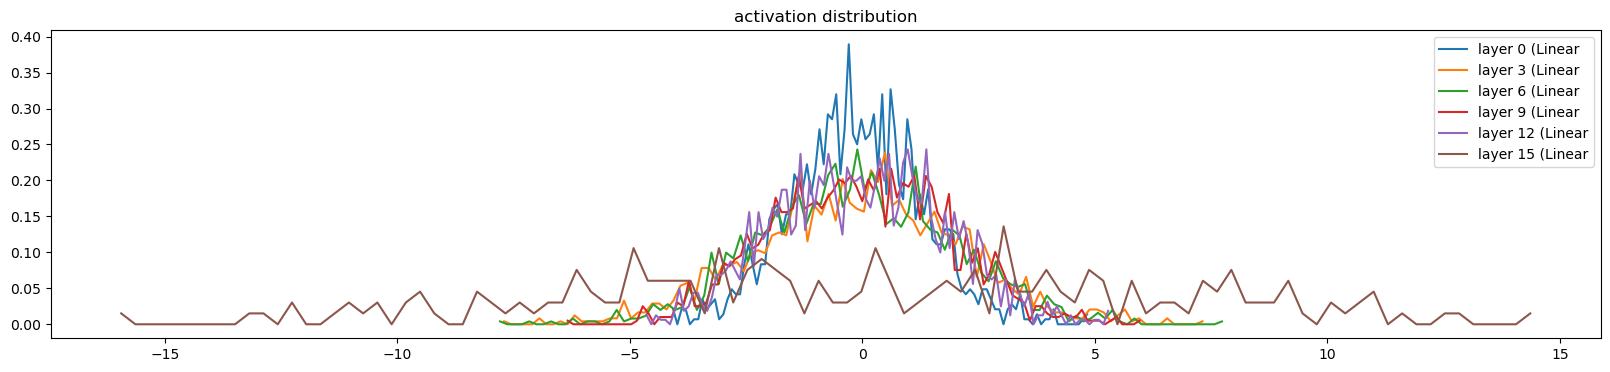

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(pytorchified.layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 8.605516e-03
layer 5 (      Tanh): mean +0.000000, std 8.786614e-03
layer 8 (      Tanh): mean -0.000000, std 8.403089e-03
layer 11 (      Tanh): mean -0.000000, std 7.437109e-03
layer 14 (      Tanh): mean +0.000000, std 6.793690e-03


Text(0.5, 1.0, 'gradient distribution')

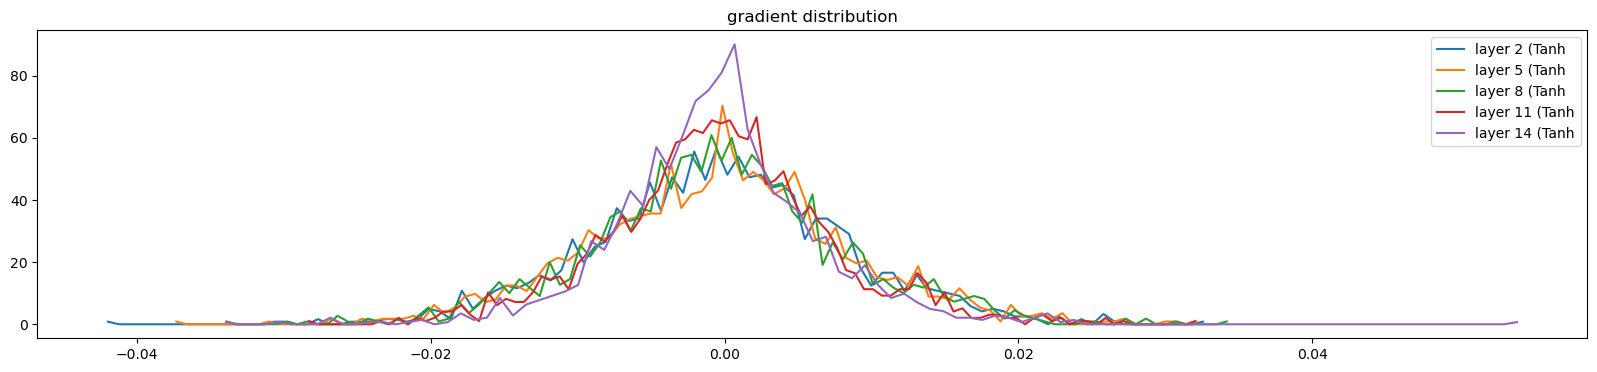

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(pytorchified.layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean -0.000000 | std 2.242864e-02 | grad:data ratio 2.123483e-02
weight  (30, 200) | mean +0.000213 | std 1.350729e-02 | grad:data ratio 4.739076e-02
weight (200, 200) | mean +0.000086 | std 7.551169e-03 | grad:data ratio 5.687748e-02
weight (200, 200) | mean -0.000057 | std 7.889955e-03 | grad:data ratio 6.042399e-02
weight (200, 200) | mean +0.000048 | std 7.393348e-03 | grad:data ratio 5.990047e-02
weight (200, 200) | mean -0.000059 | std 6.603409e-03 | grad:data ratio 5.803168e-02
weight  (200, 27) | mean -0.000068 | std 1.283261e-02 | grad:data ratio 5.572613e-02


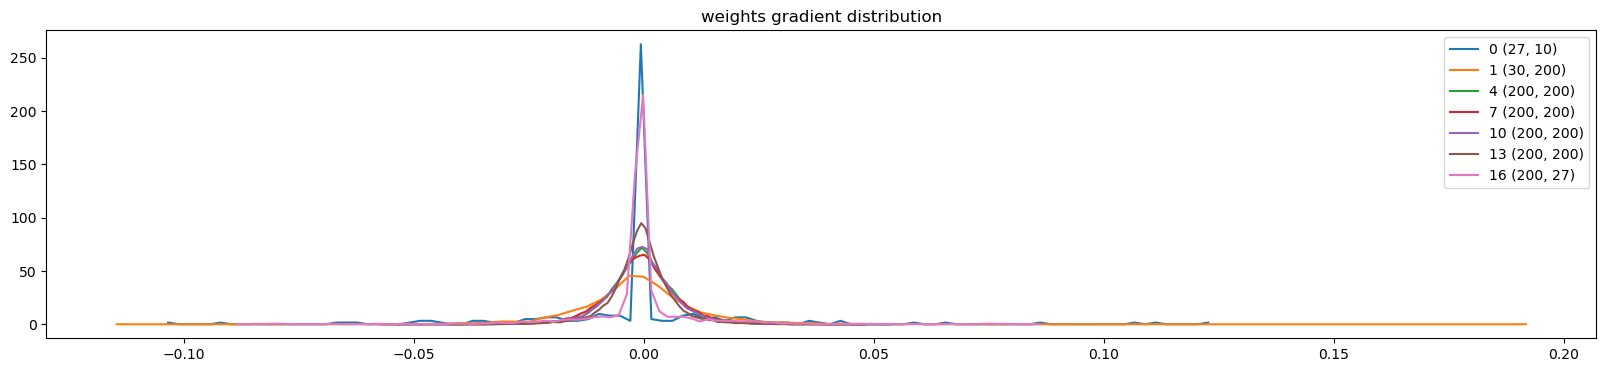

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(pytorchified.parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

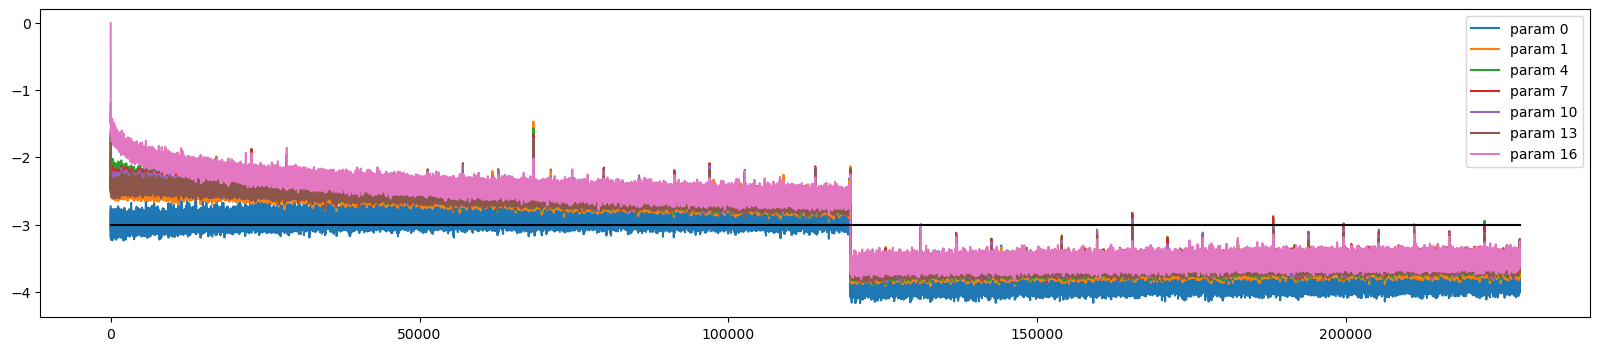

In [17]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(pytorchified.parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [18]:
for _ in range(20):
    print(pytorchified.forward(""))

nyekanzo
aje
chank
melle
keion
eilanyloril
adelony
matta
mahzer
misauna
vivian
hyett
coyd
irison
masukassione
dura
bikalys
mayan
wylanner
rosembert


## [Exercises](https://youtu.be/P6sfmUTpUmc)


### Exercise 1

TODO


### Exercise 2


In [4]:
print(pytorchified.evaluate(train_words, batchnorm=True))
print(pytorchified.evaluate(train_words, batchnorm=False))

1.958431363105774
1.958431363105774
